#### Inference + ocr + post_processing 테스트

##### 모듈 불러오기

In [1]:
import torch
import cv2
import os, io
from google.cloud import vision
from google.cloud.vision_v1 import types
import pandas as pd
import cv2
import time, datetime
from datetime import datetime
from matplotlib import pyplot as plt
import requests
import numpy as np

##### 영상처리 함수

(1) 인퍼런스

In [2]:
# 인퍼런스 함수
def inference(img):
    try:
        # train된 weight로 yolov5 model불러오기
        # path에 weight 경로 넣어주기
        model = torch.hub.load('ultralytics/yolov5', 'custom', path='best.pt')

        # inference 수행
        with torch.no_grad():
            result = model(img, 640)

        # Inference된 이미지에서 해당 영역만 추출
        crop = result.crop(save=False)

        # memory 초기화 및 캐시 삭제
        del result
        torch.cuda.empty_cache()

        return 1, crop[0]['im']

    except:
        return 0, 0

(2) 영상 전처리

In [3]:
# 영상처리 함수(전처리)
def image_change(image):
    image_gray=cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) ## BGR 색상 이미지를 회색조 이미지로 변환
    image_blur=cv2.GaussianBlur(image_gray,ksize=(3,3),sigmaX=0) ## 가우시안블러 효과를 넣어준다.

    
    k=cv2.getStructuringElement(cv2.MORPH_RECT,(2,2))


    erode = cv2.erode(image_blur,k) # 이미지의 빈 공간을 매꿔준다 (1)from matplotlib import pyplot as plt
    for i in range(2): 
        erode = cv2.erode(erode,k)

    opening=cv2.morphologyEx(erode,cv2.MORPH_OPEN,k) # 이미지의 빈 공간을 매꿔준다 (2)
    for i in range(2):
        opening=cv2.morphologyEx(opening,cv2.MORPH_OPEN,k)

    output_img=opening

    return output_img

(3) 구글 OCR

In [4]:
# openCV Image -> Bytes
def image_to_bts(frame):
    _, bts = cv2.imencode('.webp', frame)
    bts = bts.tostring()
    return bts

In [5]:
# 이미지 인식 함수(OCR) / (구글 API 코드) 
def detectText(img,infor=0): 

    # enroll environment variable
    os.environ['GOOGLE_APPLICATION_CREDENTIALS']=r'visionapi-sha.json' # key가 포함되어 있는 json파일

    # make client object
    client=vision.ImageAnnotatorClient()

    # image -> bytes -> ocr image
    content=image_to_bts(img)
    image=types.Image(content=content)

    # text detection and recognition 
    response=client.text_detection(image=image)
    texts=response.text_annotations

    if infor:
        # print text_annotation 
        for idx,text in enumerate(texts):
            print('{}) {}'.format(idx+1,text.description))
            vertices = (['({},{})'.format(vertex.x, vertex.y) for vertex in text.bounding_poly.vertices])
            print('bounds: {}\n'.format(','.join(vertices)))

    # make list with description
    list=[]
    for text in texts:
        list.append(text.description)

    return list

(4) 텍스트 후처리

In [17]:
# string -> number string
def change_num(string):
    nstring = ""
    # 문장에 있는 단어를 하나하나 검사하면서 0,1,2,3,4,5,6,7,8,9에 포함 되면 해당단어가 리스트에 추가된다.
    for i in range(0, len(string)):
        if (string[i] == '0' or
                string[i] == '1' or
                string[i] == '2' or
                string[i] == '3' or
                string[i] == '4' or
                string[i] == '5' or
                string[i] == '6' or
                string[i] == '7' or
                string[i] == '8' or
                string[i] == '9'):
            nstring += string[i]

    return nstring

# number string -> date string
def change_date(nstring):
    count = 0 
    # number string의 크기
    size=len(nstring)

    # 리턴할 string array 
    dstring=[]
    
    # 예외 데이터 (해외 주류)
    if size == 8 and date_check(nstring[4:8], nstring[2:4], nstring[0:2]):
        dstring.append("{0}-{1}-{2}".format(nstring[4:8], nstring[2:4], nstring[0:2])) 
        count += 1

    # 일반 데이터
    else:
        # 충분한 정보가 없는 경우
        if size < 4:
            dstring.append("0000-00-00")
            count += 1

        # 충분한 정보가 있는 경우
        if size == 4 or size >= 5:  # mm dd일 경우, mm dd outlier, outlier mm dd일 경우 
            # 앞에서 정보 얻기 
            month = "".join(nstring[0:2])
            day = "".join(nstring[2:4])
            dstring.append("{0}-{1}-{2}".format(datetime.today().year, month, day))  # yyyy-mm-dd 형식에 맞춰서 반환
            dstring.append("{0}-{1}-{2}".format(datetime.today().year+1, month, day))  # yyyy-mm-dd 형식에 맞춰서 반환
            count += 2
            # size가 5이상이면 뒤에서도 정보 얻음
            if size >= 5:
                month = "".join(nstring[-4:-2])
                day = "".join(nstring[-2:])
                dstring.append("{0}-{1}-{2}".format(datetime.today().year, month, day))  # yyyy-mm-dd 형식에 맞춰서 반환
                dstring.append("{0}-{1}-{2}".format(datetime.today().year+1, month, day))  # yyyy-mm-dd 형식에 맞춰서 반환
                count += 2

        if size == 6 or size >= 7:  # yy mm dd일 경우, yy mm dd outlier, outlier yy mm dd일 경우
            # 앞에서 정보 얻기 
            year = "".join(nstring[0:2])
            month = "".join(nstring[2:4])
            day = "".join(nstring[4:6])
            dstring.append("20{0}-{1}-{2}".format(year, month, day)) # yyyy-mm-dd 형식에 맞춰서 반환
            count += 1
            # size가 7이상이면 뒤에서도 정보 얻음
            if size >= 7:
                year = "".join(nstring[-6:-4])
                month = "".join(nstring[-4:-2])
                day = "".join(nstring[-2:])
                dstring.append("20{0}-{1}-{2}".format(year, month, day)) # yyyy-mm-dd 형식에 맞춰서 반환
                count += 1

        if size >= 8:  
            # case1) yyyy mm dd일 경우, yyyy mm dd outlier, outlier yyyy mm dd일 경우 
            year = "".join(nstring[0:4])
            month = "".join(nstring[4:6])
            day = "".join(nstring[6:8])
            dstring.append("{0}-{1}-{2}".format(year, month, day)) # yyyy-mm-dd 형식에 맞춰서 반환
            count += 1
            # size가 9 이상이면 뒤에서도 정보 얻음
            if size >= 9:
                year = "".join(nstring[-8:-4])
                month = "".join(nstring[-4:-2])
                day = "".join(nstring[-2:])
                dstring.append("{0}-{1}-{2}".format(year, month, day)) # yyyy-mm-dd 형식에 맞춰서 반환
                count += 1

    print(nstring,count,dstring)
    return dstring

# 올바른 유통기한인지 확인
def date_check(year,month,day):
    year = int(year)
    month = int(month)
    day = int(day)

    # -5~+5년 사이인 유톻기한만 처리 
    interval_start = datetime.today().year - 5
    interval_end = datetime.today().year + 5
    
    if year<interval_start or year>interval_end:
        return 0
    
    # 올바른 월과 일인지 확인
    if month>=1 and month<=12:
        if month == 1 or month == 3 or month == 5 or month == 7 or month == 8 or month == 10 or month ==12:
            if day>=1 and day<=31:
                return 1
        elif month == 4 or month == 6 or month == 9 or month == 11:
            if day>=1 and day<=30:
                return 1
        elif month == 2:
            # 윤년 판별
            if (year%100 != 0 and year%4 == 0) or (year%400 == 0):
                if day>=1 and day <=29:
                    return 1
            elif day >= 1 and day <= 28:
                return 1
    return 0

# 후처리 함수 (yyyy-mm-dd)
def result_word(ocr_list, infor=0):
    n = len(ocr_list) # ocr_list의 크기

    n_list = [] # number string list
    d_list = [] # date string list
    a_list = set([]) # available date string list (set)

    if infor:
        print("* 입력:{}".format(ocr_list))

        # string -> number string
        for i in range(0,n-1):
            n_list.append(change_num(ocr_list[i+1]))
        # 정보가 나눠져 있는 경우를 대비해서 합칩 ex) 22,10,11
        if n == 3:
            n_list.append(change_num(ocr_list[1] + ocr_list[2]))
        elif n == 4:
            n_list.append(change_num(ocr_list[1] + ocr_list[2]))
            n_list.append(change_num(ocr_list[2] + ocr_list[3]))
            n_list.append(change_num(ocr_list[1] + ocr_list[2] + ocr_list[3]))
        print("* ocr_list -> number_list:",n_list,sep=" ")

        # number string -> date string (length:5,7,9이상 -> any date string return)
        for i in range(len(n_list)):
            c_d_output = change_date(n_list[i])
            for j in range(len(c_d_output)):
                d_list.append(c_d_output[j])
        print("* number_list -> date_list:",d_list,sep=" ")

        # check availability
        for i in range(len(d_list)):
            # year, month, day of list[i]
            year = d_list[i][0:4]
            month = d_list[i][5:7]
            day = d_list[i][8:10]
            # check if date string is available
            # if date string is available -> store date to a_list
            if date_check(year, month, day):
                a_list.add(d_list[i])
        print("* date_list -> available_date_list:",a_list,sep=" ")

        if len(a_list)>=10:
            return a_list[0:7]
        elif len(a_list)>0:
            return a_list
        else:
            return 0

    else:
        # string -> number string
        for i in range(0,n-1):
            n_list.append(change_num(ocr_list[i+1]))

        # number string -> date string (length:5,7,9이상 -> any date string return)
        for i in range(len(n_list)):
            c_d_output = change_date(n_list[i])
            for j in range(len(c_d_output)):
                d_list.append(c_d_output[j])
        
        # check availability
        for i in range(len(d_list)):
            # year, month, day of list[i]
            year = d_list[i][0:4]
            month = d_list[i][5:7]
            day = d_list[i][8:10]
            # check if date string is available
            # if date string is available -> store date to a_list
            if date_check(year, month, day):
                a_list.add(d_list[i])

        if len(a_list)>=10:
            return a_list[0:7]
        elif len(a_list)>0:
            return a_list
        else:
            return 0

CV2 영상 출력

In [9]:
# imshow function (cv2 image -> plt image -> plt.show)
# cv2 image를 plt image로 출력 
def imshow(in_img):
    out_img = cv2.cvtColor(in_img,cv2.COLOR_BGR2RGB) 
    plt.figure(figsize=(20,20))
    plt.imshow(out_img)
    plt.axis('off')
    plt.show()

##### 단계별로 확인

In [10]:
# 파일 이름 및 경로 설정
FILE_NAME='안성현(0).jpg' 
FOLDER_PATH="pictures" 
FILE_PATH=os.path.join(FOLDER_PATH, FILE_NAME)

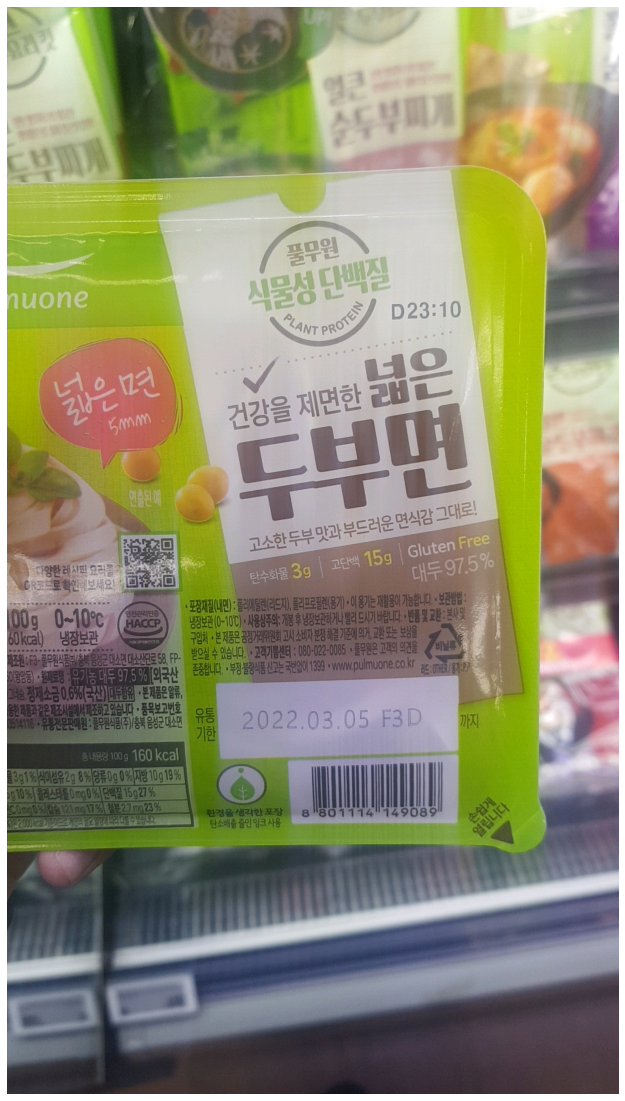

In [11]:
# 이미지 객체 생성 및 확인 
org_img=cv2.imread(FILE_PATH)
imshow(org_img)

Using cache found in /home/ahnsunghyun/.cache/torch/hub/ultralytics_yolov5_master
fatal: (현재 폴더 또는 상위 폴더 중 일부가) 깃 저장소가 아닙니다: .git
YOLOv5 🚀 2022-4-3 torch 1.8.2+cu111 CUDA:0 (NVIDIA GeForce RTX 2060, 5926MiB)

Fusing layers... 
Model summary: 213 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
Adding AutoShape... 
/tmp/ipykernel_14482/1527593960.py:8: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


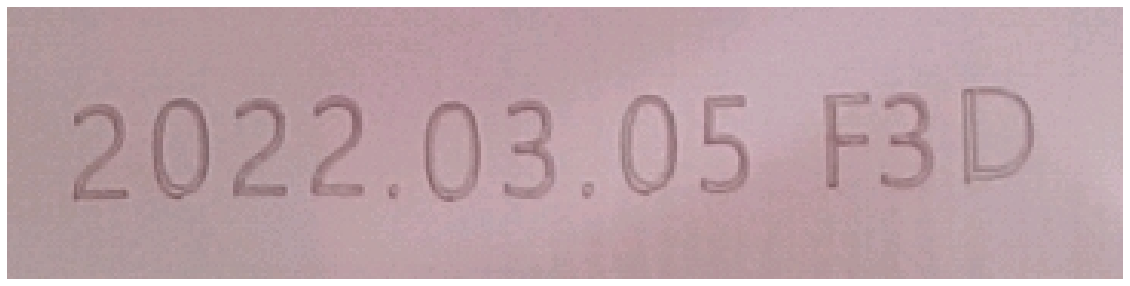

In [12]:
# 인퍼런스 함수 호출
s,img=inference(org_img)

if s:
    imshow(img)
else:
    print("can't find!!")

/tmp/ipykernel_14482/1527593960.py:8: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


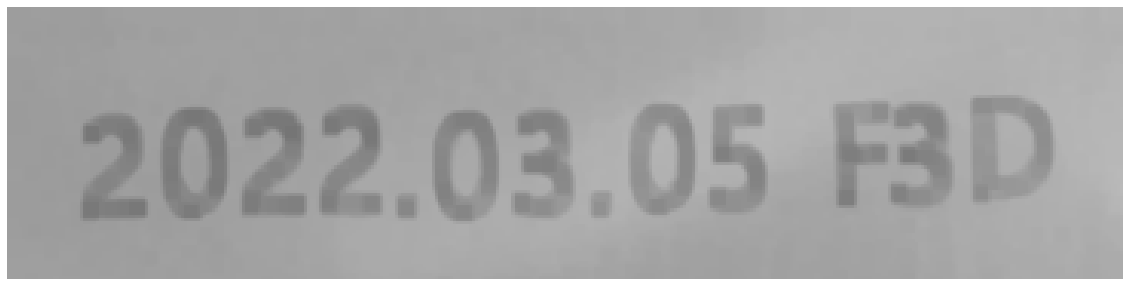

In [13]:
# 영상 전처리 함수 호출
pre_img=image_change(img) 
imshow(pre_img)

In [14]:
# OCR 함수 호출
ocr_text_list=detectText(pre_img,1)
print(ocr_text_list)

/tmp/ipykernel_14482/1923968608.py:4: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  bts = bts.tostring()


1) 2022.03.05 F3D

bounds: (23,28),(341,28),(341,71),(23,71)

2) 2022.03.05
bounds: (23,32),(247,28),(248,67),(24,71)

3) F3D
bounds: (270,30),(340,29),(341,64),(271,65)

['2022.03.05 F3D\n', '2022.03.05', 'F3D']


In [18]:
# 텍스트 처리 함수 호출
print(result_word(ocr_text_list,1)) 

* 입력:['2022.03.05 F3D\n', '2022.03.05', 'F3D']
* ocr_list -> number_list: ['20220305', '3', '202203053']
20220305 7 ['2022-20-22', '2023-20-22', '2022-03-05', '2023-03-05', '2020-22-03', '2022-03-05', '2022-03-05']
3 1 ['0000-00-00']
202203053 8 ['2022-20-22', '2023-20-22', '2022-30-53', '2023-30-53', '2020-22-03', '2020-30-53', '2022-03-05', '0220-30-53']
* number_list -> date_list: ['2022-20-22', '2023-20-22', '2022-03-05', '2023-03-05', '2020-22-03', '2022-03-05', '2022-03-05', '0000-00-00', '2022-20-22', '2023-20-22', '2022-30-53', '2023-30-53', '2020-22-03', '2020-30-53', '2022-03-05', '0220-30-53']
* date_list -> available_date_list: {'2022-03-05', '2023-03-05'}
{'2022-03-05', '2023-03-05'}


##### 한 번에 확인 (+ 시간 체크)

/tmp/ipykernel_14482/1527593960.py:8: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()
Using cache found in /home/ahnsunghyun/.cache/torch/hub/ultralytics_yolov5_master
fatal: (현재 폴더 또는 상위 폴더 중 일부가) 깃 저장소가 아닙니다: .git
YOLOv5 🚀 2022-4-3 torch 1.8.2+cu111 CUDA:0 (NVIDIA GeForce RTX 2060, 5926MiB)

Fusing layers... 
Model summary: 213 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
Adding AutoShape... 
/tmp/ipykernel_14482/1923968608.py:4: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  bts = bts.tostring()


['BBE:08.09.2022\n21:26 251\n', 'BBE:08.09.2022', '21:26', '251']
* 입력:['BBE:08.09.2022\n21:26 251\n', 'BBE:08.09.2022', '21:26', '251']
* ocr_list -> number_list: ['08092022', '2126', '251', '080920222126', '2126251', '080920222126251']
08092022 1 ['2022-09-08']
2126 2 ['2022-21-26', '2023-21-26']
251 1 ['0000-00-00']
080920222126 8 ['2022-08-09', '2023-08-09', '2022-21-26', '2023-21-26', '2008-09-20', '2022-21-26', '0809-20-22', '2022-21-26']
2126251 6 ['2022-21-26', '2023-21-26', '2022-62-51', '2023-62-51', '2021-26-25', '2012-62-51']
080920222126251 8 ['2022-08-09', '2023-08-09', '2022-62-51', '2023-62-51', '2008-09-20', '2012-62-51', '0809-20-22', '2212-62-51']
* number_list -> date_list: ['2022-09-08', '2022-21-26', '2023-21-26', '0000-00-00', '2022-08-09', '2023-08-09', '2022-21-26', '2023-21-26', '2008-09-20', '2022-21-26', '0809-20-22', '2022-21-26', '2022-21-26', '2023-21-26', '2022-62-51', '2023-62-51', '2021-26-25', '2012-62-51', '2022-08-09', '2023-08-09', '2022-62-51', '2

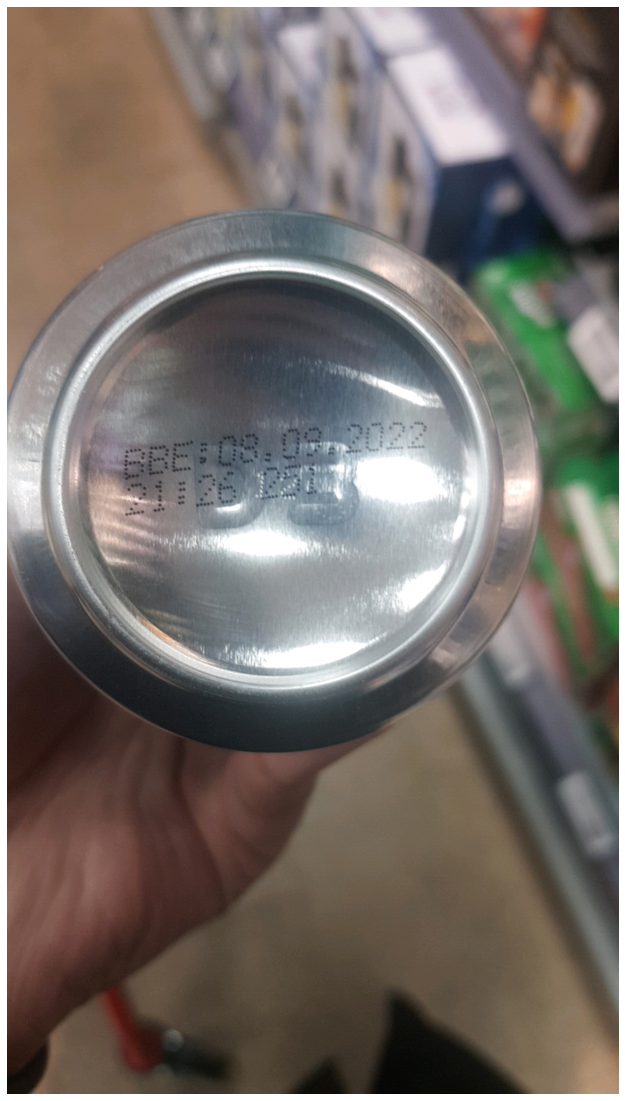

In [19]:
# 파일 이름 및 경로 설정
FILE_NAME='안성현(92).jpg' 
FOLDER_PATH="pictures" 
FILE_PATH=os.path.join(FOLDER_PATH, FILE_NAME)

# 원본 영상 확인
org_img=cv2.imread(FILE_PATH)
imshow(org_img)

start = time.time() # << 시간 측정 시작 >>

# 인퍼런스 함수 호출
s, img=inference(org_img)

if s:
    # 영상 전처리 함수 호출
    pre_img=image_change(img) 

    # OCR 함수 호출
    ocr_text_list=detectText(pre_img)
    print(ocr_text_list)

    # 텍스트 처리 함수 호출
    result = result_word(ocr_text_list,1)

    # OCR 성공 시 출력
    if result:
        print(result)
    else:
        print("can't find!!")

else:
    print("can't find!!")

end = time.time() # << 시간 측정 끝 >>
sec = (end - start)
print('소요 시간: {:.2f}초'.format(sec))

##### 카카오 이미지 URL -> OCR

In [20]:
def url2img(url):
    _url = url 
    image_nparray = np.asarray(bytearray(requests.get(_url).content),
                               dtype=np.uint8)  # 전처리 (url image -> nparray)
    image = cv2.imdecode(image_nparray, cv2.IMREAD_COLOR)  # 전처리 (nparray -> cv2 image)
    return image

/tmp/ipykernel_14482/1527593960.py:8: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()
Using cache found in /home/ahnsunghyun/.cache/torch/hub/ultralytics_yolov5_master
fatal: (현재 폴더 또는 상위 폴더 중 일부가) 깃 저장소가 아닙니다: .git
YOLOv5 🚀 2022-4-3 torch 1.8.2+cu111 CUDA:0 (NVIDIA GeForce RTX 2060, 5926MiB)

Fusing layers... 
Model summary: 213 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
Adding AutoShape... 
/tmp/ipykernel_14482/1923968608.py:4: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  bts = bts.tostring()


20221005 7 ['2022-20-22', '2023-20-22', '2022-10-05', '2023-10-05', '2020-22-10', '2022-10-05', '2022-10-05']
 1 ['0000-00-00']
{'2022-10-05', '2023-10-05'}


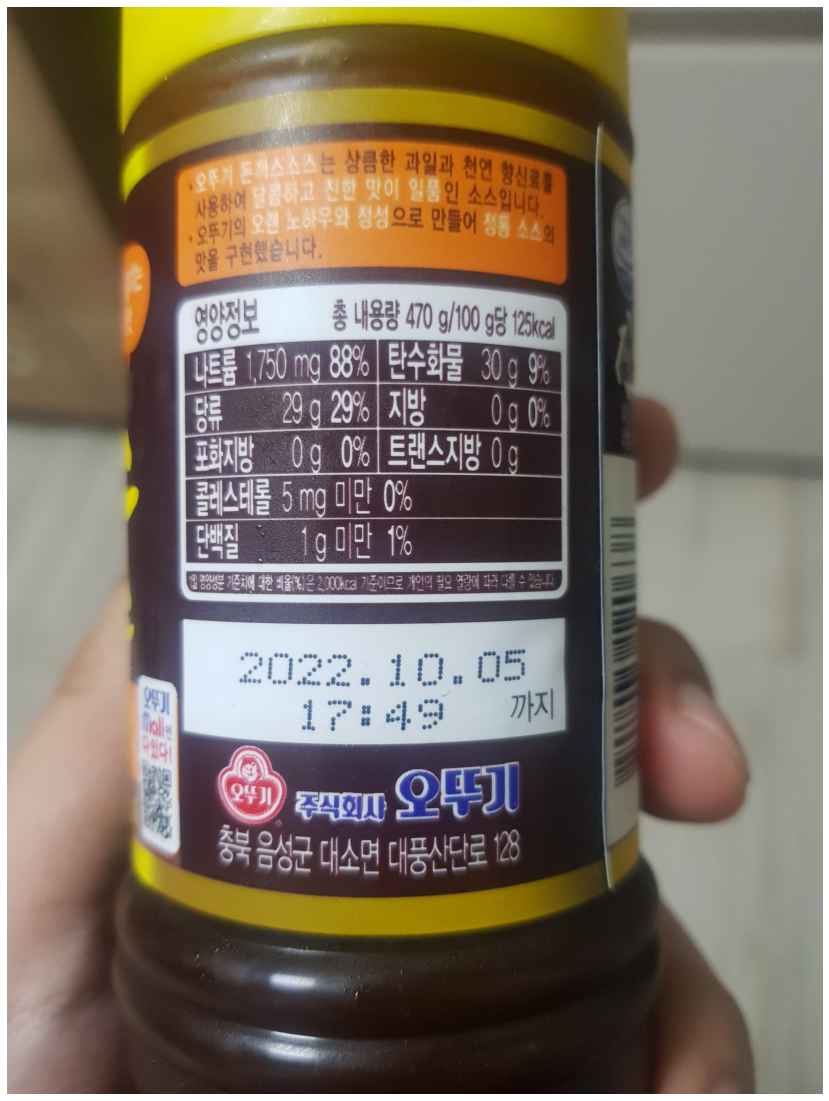

In [24]:
addr='http://dn-m.talk.kakao.com/talkm/bl436znhuQh/Qe2B357aKIVCQqv4nPA14K/i_02b9b3aa57f1.jpg'
org_img=url2img(addr)
imshow(org_img)

s,img=inference(org_img)

if s:
    pre_img=image_change(img) 
    ocr_text_list=detectText(pre_img)
    result = result_word(ocr_text_list)

    if result:
        print(result)
    else:
        print("can't find!!")

else:
    print("can't find!!")